# 

In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pyspark.sql import SparkSession,DataFrame
from pyspark.sql.functions import udf,col,split,explode_outer,regexp_replace,from_json,date_format,to_timestamp,expr,from_utc_timestamp,lit
from pyspark.sql.types import DoubleType,StructType, StructField, ArrayType, StringType, TimestampType
import pytz
from cryptography.fernet import Fernet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os


In [78]:
def flatten_json(df):

    """
    Flattens a DataFrame with complex nested fields (Arrays and Structs) by converting them into individual columns.
   
    Parameters:
    - df: The input DataFrame with complex nested fields
   
    Returns:
    - The flattened DataFrame with all complex fields expanded into separate columns.
   """
   # compute Complex Fields (Lists and Structs) in Schema   
    complex_fields = dict([(field.name, field.dataType,)
                             for field in df.schema.fields
                             if type(field.dataType) == ArrayType or  type(field.dataType) == StructType])
    print(df.schema)
    print("")
    while len(complex_fields)!=0:
      col_name=list(complex_fields.keys())[0]
      print ("Processing :"+col_name+" Type : "+str(type(complex_fields[col_name])))

      # if (type(complex_fields[col_name]) == StringType):
          # print(col_name)
          # print(df.withColumn("new_col",startswith(col_name[0],'{')))
          # print("true")
      # if StructType then convert all sub element to columns.
      # i.e. flatten structs
      if (type(complex_fields[col_name]) == StructType) :
         expanded = [col(col_name+'.'+k).alias(col_name+'_'+k) for k in [ n.name for n in  complex_fields[col_name]]]
         df=df.select("*", *expanded).drop(col_name)
    
      # if ArrayType then add the Array Elements as Rows using the explode function
      # i.e. explode Arrays
      elif (type(complex_fields[col_name]) == ArrayType):    
         df=df.withColumn(col_name,explode_outer(col_name))
    
      # recompute remaining Complex Fields in Schema       
      complex_fields = dict([(field.name, field.dataType)
                             for field in df.schema.fields
                             if type(field.dataType) == ArrayType or  type(field.dataType) == StructType])
    return df

In [79]:
# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("SparkByExamples.com") \
      .getOrCreate() 


In [80]:

# localTime = pytz.timezone("Malaysia/Kuala_Lumpur") 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        #bronze_df to load to datalake/data storage. Bronze layer usually is one to one with source
        bronze_df = spark.read.format("json").load(os.path.join(dirname, filename))
        bronze_row = bronze_df.count()
        print(f"Bronze DataFrame Rows count : {bronze_row}")
        # bronze_df.write.format("delta").mode("append").save(os.path.join(dirname, "cc_sample_transaction1.json"))
        
       

/kaggle/input/cc-sample-data/cc_sample_transaction.json
Bronze DataFrame Rows count : 1296675


Identify dirty data can be done by execu distinct attributes to find the pattern of the values that can be excluded to make the data clean and valuable. For example for name, we should not expect any symbol or number. You can also use data profiling tools to get the summary of your data to check of consistency and correctness.
For attributes that must not be nullable, if null exist it will make the data become invalid, we can remove it in transformation layer. Similarly with duplicates data, can be removed/excluded in transformation layer.

In [81]:
        # Initially can execute bronze_df.printSchema() to get the schema to predefined the attributes.
        #Defines the schemas of the attributes
        personal_detail_schemas = StructType([StructField("person_name", StringType(), True),
                    StructField("gender", StringType(), True),
                    StructField("address", StringType(), True),          
                    StructField("lat", StringType(), True),
                    StructField("long", StringType(), True),
                    StructField("city_pop", StringType(), True),
                    StructField("job", StringType(), True),
                    StructField("dob", StringType(), True)],
                    )
        address_schemas =  StructType([StructField("street", StringType(), True),
                                                        StructField("city", StringType(), True),
                                                        StructField("state", StringType(), True),
                                                        StructField("zip", StringType(), True)])
        #Transformed the data into the preferable data type and format
        bronze_df=bronze_df.withColumn("merch_eff_time",bronze_df.merch_eff_time.cast(DoubleType()))\
        .withColumn("merch_last_update_time",bronze_df.merch_last_update_time.cast(DoubleType()))\
        .withColumn("personal_detail", from_json(col("personal_detail"), personal_detail_schemas))
        bronze_df=bronze_df.withColumn("merch_eff_time",date_format(to_timestamp(bronze_df["merch_eff_time"]/1000000) + expr("INTERVAL 8 HOURS"),"yyyy-mm-dd HH:mm:ss.SSSS Z"))\
        .withColumn("merch_last_update_time",date_format(to_timestamp(bronze_df["merch_last_update_time"]/1000) + expr("INTERVAL 8 HOURS"),"yyyy-mm-dd HH:mm:ss.SSSS Z"))\
        .withColumn("address", from_json(col("personal_detail.address"), address_schemas))\
        .withColumn("trans_date_trans_time",date_format(to_timestamp(bronze_df["trans_date_trans_time"]) + expr("INTERVAL 8 HOURS"),"yyyy-mm-dd HH:mm:ss.SSSS Z"))
        # df.select(col("merch_last_update_time"),col("merch_eff_time"),col("trans_date_trans_time")).show(n=30,truncate=False)
        flatten_df = flatten_json(bronze_df)
        # flatten_df.select(col("personal_detail_person_name"),col("merch_last_update_time"),col("merch_eff_time"),col("trans_date_trans_time")).show(n=100,truncate=False)
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], ", !",""))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], "!",""))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"],", ,",","))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"],", ",","))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], ",eeeee",""))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], " NOOOO",""))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], "@",","))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], "/",","))
        flatten_df = flatten_df.withColumn("personal_detail_person_name",regexp_replace(flatten_df["personal_detail_person_name"], "\|",","))
        # flatten_df.select(col("personal_detail_person_name")).show(n=100,truncate=False)
        flatten_df = flatten_df.withColumn("personal_detail_person_name", split(flatten_df["personal_detail_person_name"], ',\s*'))
        flatten_df = flatten_df.withColumn("first", flatten_df["personal_detail_person_name"][0])\
        .withColumn("last", flatten_df["personal_detail_person_name"][1])
        # flatten_df.select(col("first"),col("last")).show(n=100,truncate=False)
        flatten_df = flatten_df.drop("personal_detail_address")\
        .drop("personal_detail_person_name")
        flatten_df = flatten_df.withColumnsRenamed({
        "personal_detail_gender": "gender",
        "personal_detail_lat": "lat",
        "personal_detail_long": "long",
        "personal_detail_city_pop": "city_pop",
        "personal_detail_job": "job",
        "personal_detail_dob": "dob",
        "address_street": "street",
        "address_city": "city",
        "address_state": "state",
        "address_zip": "zip"
        })


StructType([StructField('Unnamed: 0', StringType(), True), StructField('amt', StringType(), True), StructField('category', StringType(), True), StructField('cc_bic', StringType(), True), StructField('cc_num', StringType(), True), StructField('is_fraud', StringType(), True), StructField('merch_eff_time', StringType(), True), StructField('merch_last_update_time', StringType(), True), StructField('merch_lat', StringType(), True), StructField('merch_long', StringType(), True), StructField('merch_zipcode', StringType(), True), StructField('merchant', StringType(), True), StructField('personal_detail', StructType([StructField('person_name', StringType(), True), StructField('gender', StringType(), True), StructField('address', StringType(), True), StructField('lat', StringType(), True), StructField('long', StringType(), True), StructField('city_pop', StringType(), True), StructField('job', StringType(), True), StructField('dob', StringType(), True)]), True), StructField('trans_date_trans_time

For Handling PII data, We can encrypt it using fernet library in the transformation/silver layer. For bronze layer, we can manage it by adding a role based access control (rbac) to restrict only certain user can access it. Potentially only system can access. Each individual are restricted in to access the PII only upon request and the request has been justified and approved by managers.

In [82]:
        # encrypt func
        def encrypt_data(plain_text, KEY):
            f = Fernet(KEY)
            encrip_text = f.encrypt(str(plain_text).encode()).decode()
            return encrip_text
        encrypt_udf = udf(encrypt_data, StringType())
        # generate the encryption key
        Key = Fernet.generate_key()
        enc_df = flatten_df.withColumn("cc_num", encrypt_udf(col('cc_num'), lit(Key))) 
        #silver_df layer is after the data being transformed and cleaned
        silver_df = enc_df.dropDuplicates()
        silver_row = silver_df.count()
        print(f"Silver DataFrame Rows count : {silver_row}")
        silver_df.show()

Silver DataFrame Rows count : 1296675
+----------+------+--------------+-----------+--------------------+--------+--------------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+--------------------+------+-------+---------+--------+--------------------+----------+--------------------+--------------+-----+-----+---------+--------+
|Unnamed: 0|   amt|      category|     cc_bic|              cc_num|is_fraud|      merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|            merchant|trans_date_trans_time|           trans_num|gender|    lat|     long|city_pop|                 job|       dob|              street|          city|state|  zip|    first|    last|
+----------+------+--------------+-----------+--------------------+--------+--------------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+-------

to identify the potential customer based on the number of registered credit card in each state

In [83]:
        table = spark.sql('''
        select state, count(distinct cc_num) as num_of_cc
        from {tb}
        group by state order by 2 desc limit 5
        ''', tb=silver_df)
        table.show(n=500,truncate=False)
        


+-----+---------+
|state|num_of_cc|
+-----+---------+
|TX   |94876    |
|NY   |83501    |
|PA   |79847    |
|CA   |56360    |
|OH   |46480    |
+-----+---------+



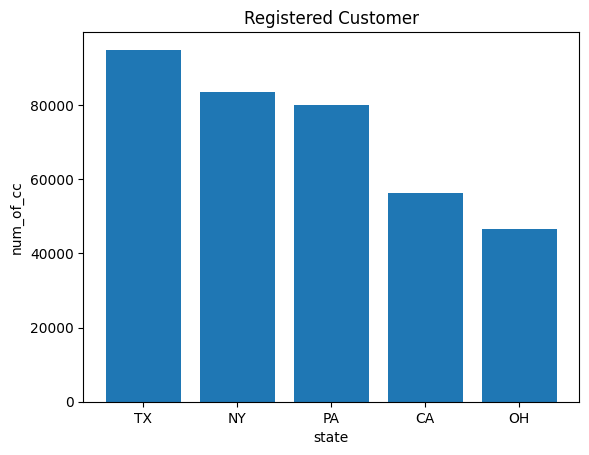

In [84]:
        data = table.toPandas()
        plt.bar(data.state,data.num_of_cc)
        plt.title("Registered Customer")

        # Setting the X and Y labels

        plt.xlabel('state')

        plt.ylabel('num_of_cc')

        # Adding the legends

        plt.show()

to identify customer credit card use for potential fraud or suspicious use

In [85]:
        #to identify credit card use for fraud
        table2 = spark.sql('''
        select *
        from {tb}
        where is_fraud = '1'
        ''', tb=silver_df)
        table2.show(n=5,truncate=False)

+----------+------+-------------+--------+------------------------------------------------------------------------------------------------------------------------+--------+------------------------------+------------------------------+---------+------------------+-------------+---------------------------------+------------------------------+--------------------------------+------+-------+--------+--------+----------------------------------+----------+-----------------------------+---------+-----+-----+--------+--------+
|Unnamed: 0|amt   |category     |cc_bic  |cc_num                                                                                                                  |is_fraud|merch_eff_time                |merch_last_update_time        |merch_lat|merch_long        |merch_zipcode|merchant                         |trans_date_trans_time         |trans_num                       |gender|lat    |long    |city_pop|job                               |dob       |street               

number of credit cards that are potentialy fraudulent or suspicious in each state.

In [86]:

        table3 = spark.sql('''
        select state, count(distinct cc_num) as num_of_cc
        from {tb}
        where is_fraud = '1'
        group by state order by 2 desc limit 5
        ''', tb=silver_df)
        table3.show(n=500,truncate=False)

+-----+---------+
|state|num_of_cc|
+-----+---------+
|NY   |555      |
|TX   |479      |
|PA   |458      |
|CA   |326      |
|OH   |321      |
+-----+---------+



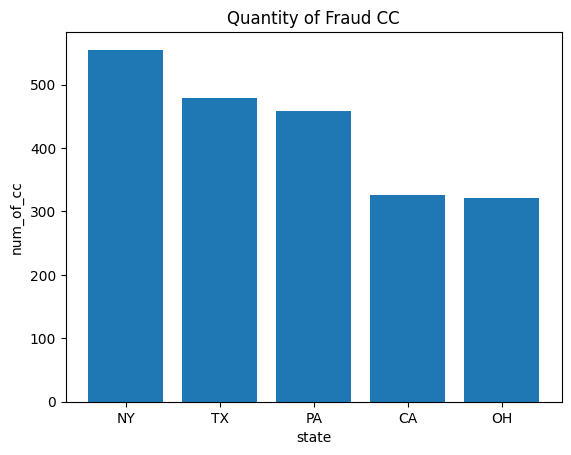

In [87]:
        data3 = table3.toPandas()
        plt.bar(data3.state,data3.num_of_cc)
        plt.title("Quantity of Fraud CC")

        # Setting the X and Y labels

        plt.xlabel('state')

        plt.ylabel('num_of_cc')

        # Adding the legends

        plt.show()

Identify which segment customer usage of credit card to offer better credit card plan / type for better customer satisfaction

In [88]:
        table4 = spark.sql('''
        with cust_transaction as (select cc_num, first, last, category, count(*) as category_count, sum(amt) as total_amount
        from {tb}
        where is_fraud = '0'
        group by 1,2,3,4
        )
        select cc_num, first, last category,category_count, total_amount from (
        select *, rank() over (partition by cc_num order by total_amount desc) rnk from cust_transaction)
        where rnk <=5
        order by cc_num, total_amount desc
 
        ''', tb=silver_df)
        table4.show(n=100,truncate=False)

+------------------------------------------------------------------------------------------------------------------------+-----------+-----------+--------------+------------+
|cc_num                                                                                                                  |first      |category   |category_count|total_amount|
+------------------------------------------------------------------------------------------------------------------------+-----------+-----------+--------------+------------+
|gAAAAABoP7u---32IgdTxZ9btWOvcDTgyUzLpOa1uhxPKiOs92IIvfTalCTcRnxF2Dv8DLuyI66f9gIosJne7WGDkOXaydZ0L2HqN2gSK1UmfeK3Eo3-coY=|Ashley     |Cabrera    |1             |114.94      |
|gAAAAABoP7u---K0V_rSzC7DMiiNzxViBbQH8aHPgv4Mjwbx6twRx1SH5yNJ7c2XfVVMjHuvr6kvlxxXLQlR2ykLn_T6ol7xUQ==                    |Jamie      |Olson      |1             |5.27        |
|gAAAAABoP7u---L9NimsV6Tzve-CcBigi1DSLyDalTHbtocCC54iG3_q40iRcvcsAIF-C8oE0m1dQ4vCV-8nfKIGxPi77Xh7jQ==                    |Dan